# Google requires you to log in to use this notebook.
This notebook is the variation of the one found at :
https://github.com/juglab/n2v

It can be used to 
- Load images from google drive
- Train a model for Noise2Void
- Batch process a folder of images using the model that has been generated

The N2V article can found at:
https://arxiv.org/abs/1811.10980

# Noise2Void - 3D Example

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0-rc1


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Specifically needed for Google Colab: 
# noise2void needs to be installed every time!
!pip install n2v

In [0]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

# Training Data Preparation

For training we load __one__ set of low-SNR images and use the <code>N2V_DataGenerator</code> to extract training <code>X</code> and validation <code>X_val</code> patches.

In [0]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [0]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = datagen.load_imgs_from_directory(directory = "gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/Train", dims='ZYX')

# Let's look at the shape of the image
print(imgs[0].shape)
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(1, 5, 1024, 1024, 1)


In [0]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:

# Here we extract patches for training and validation. Make sure to adapt the Z dimension to the number of slices in the stack.
patches = datagen.generate_patches_from_list(imgs[:1], shape=(4, 64, 64))

Generated patches: (1800, 4, 64, 64, 1)


In [0]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:600]
X_val = patches[600:]

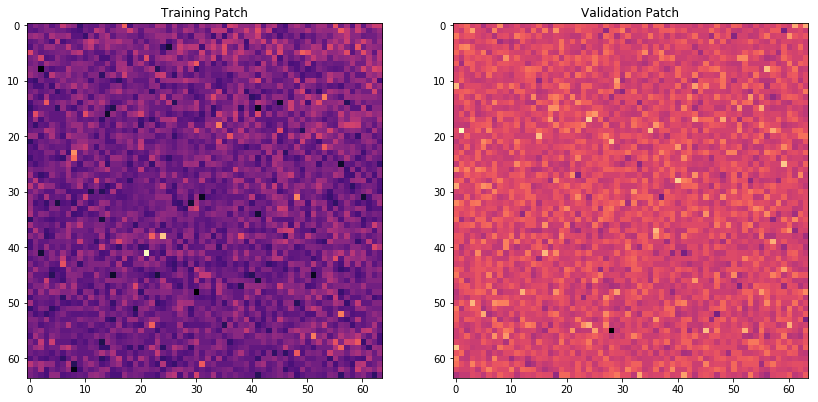

In [0]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,1,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,2,...,0],cmap='magma')
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 64 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 10 and <code>train_steps_per_epoch</code> to only 10. <br>For better results we suggest values of 100, and a few dozen, respectively.

In [0]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. Modify the patch shape to match the original settings.
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=100,train_epochs=50, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=1.6, n2v_patch_shape=(4, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'axes': 'ZYXC',
 'batch_norm': True,
 'mean': '106.2497',
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (4, 64, 64),
 'n2v_perc_pix': 1.6,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 3,
 'std': '11.710026',
 'train_batch_size': 4,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 50,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': False}

In [0]:
# a name used to identify the model
model_name = 'Rush_3D'
# the base directory in which our model will live
basedir = 'gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

# Training

Training the model will likely take some time. 

In [0]:
history = model.train(X, X_val)


Epoch 1/50
100/100 [==============================] - 21s 213ms/step - loss: 0.5905 - n2v_mse: 0.5905 - n2v_abs: 0.4730 - val_loss: 0.3525 - val_n2v_mse: 0.3525 - val_n2v_abs: 0.3763
Epoch 2/50
100/100 [==============================] - 17s 173ms/step - loss: 0.3692 - n2v_mse: 0.3692 - n2v_abs: 0.3959 - val_loss: 0.2351 - val_n2v_mse: 0.2351 - val_n2v_abs: 0.3343
Epoch 3/50
100/100 [==============================] - 17s 170ms/step - loss: 0.2512 - n2v_mse: 0.2512 - n2v_abs: 0.3466 - val_loss: 0.2821 - val_n2v_mse: 0.2821 - val_n2v_abs: 0.3477
Epoch 4/50
100/100 [==============================] - 17s 169ms/step - loss: 0.3209 - n2v_mse: 0.3209 - n2v_abs: 0.3703 - val_loss: 0.2399 - val_n2v_mse: 0.2399 - val_n2v_abs: 0.3399
Epoch 5/50
100/100 [==============================] - 17s 169ms/step - loss: 0.2577 - n2v_mse: 0.2577 - n2v_abs: 0.3443 - val_loss: 0.2263 - val_n2v_mse: 0.2263 - val_n2v_abs: 0.3241
Epoch 6/50
100/100 [==============================] - 17s 167ms/step - loss: 0.2532 -

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


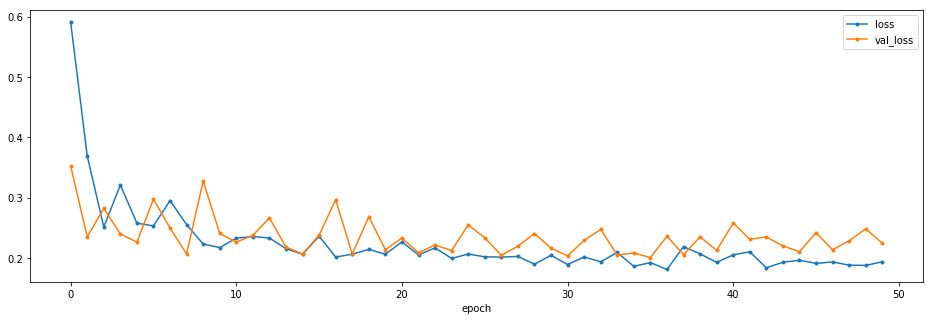

In [0]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Prediction
Here we will simply use the same data as during training and denoise it using our network.

In [0]:
# We load the data we want to process.
img = imread('gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/Train/train.tif')

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

100%|██████████| 32/32 [00:05<00:00,  6.68it/s]


### Show results on training data...

In [0]:
# Let's look at the results.
plt.figure(figsize=(30,30))

# We show the noisy input...
plt.subplot(1,2,1)
plt.imshow(np.max(img,axis=0),
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Input');

# and the result.
plt.subplot(1,2,2)
plt.imshow(np.max(pred,axis=0), 
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Prediction');

Output hidden; open in https://colab.research.google.com to view.

### Show results on validation data...

In [0]:
save_tiff_imagej_compatible('gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/Validation/prediction.tif', pred, 'ZYX')

/usr/local/lib/python3.6/dist-packages/csbdeep/io/__init__.py:40: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

_Note:_ in Google Colab you can find the saved file in the file-browsing panel on the left. There you can also download trained models, saved, models, weights, etc.

To use the model in Fiji you first need to downgrad Tensorflow and CUDA. Use the appropriate jupiter notebook.

In [0]:
model.export_TF()


Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/models/Rush_3D/TF_SavedModel.zip


# Process other images !

This part allow to batch process images using the model that has just been generated

In [0]:
from pathlib import Path
import os
from tifffile import imread

# Getting the current work directory (cwd)
thisdir = Path("gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch")
outputdir = Path("gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batchout")



suffix = '.tif'



# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='ZYX', n_tiles=(2,4,4))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename + suffix), pred_train, axes='ZYX')         


gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 2_XY1550222138_Z0_T03_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 2_XY1550222138_Z0_T04_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 2_XY1550222138_Z0_T01_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 2_XY1550222138_Z0_T02_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 2_XY1550222138_Z0_T00_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 1_XY1550221920_Z0_T3_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 1_XY1550221920_Z0_T2_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 1_XY1550221920_Z0_T4_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/batch/FNgfp ER RUSH - Position 3 - 3_XY1550222523_Z0_T09_C1.tif
gdrive/My Drive/NOIse2VOID/Martina_Rush/


100%|██████████| 32/32 [00:05<00:00,  6.53it/s]
/usr/local/lib/python3.6/dist-packages/csbdeep/io/__init__.py:40: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))

100%|██████████| 32/32 [00:05<00:00,  6.30it/s]

100%|██████████| 32/32 [00:05<00:00,  5.89it/s]

100%|██████████| 32/32 [00:05<00:00,  5.55it/s]

100%|██████████| 32/32 [00:05<00:00,  6.10it/s]

100%|██████████| 32/32 [00:05<00:00,  6.25it/s]

100%|██████████| 32/32 [00:05<00:00,  6.03it/s]

100%|██████████| 32/32 [00:05<00:00,  6.42it/s]

100%|██████████| 32/32 [00:05<00:00,  6.60it/s]

100%|██████████| 32/32 [00:05<00:00,  6.43it/s]

100%|██████████| 32/32 [00:05<00:00,  6.53it/s]

100%|██████████| 32/32 [00:05<00:00,  5.67it/s]

100%|██████████| 32/32 [00:05<00:00,  6.46it/s]

100%|██████████| 32/32 [00:05<00:00,  6.17it/s]

100%|██████████| 32/32 [00:05<00:00,  6.56it/s]

100%|██████████| 